In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # converts text to numerical features (TF-IDF)
from sklearn.cluster import KMeans # clusters numerical representations (tries to distribute as even size as possible)
from sentence_transformers import SentenceTransformer # converts sentences into dense embeddings
from umap import UMAP # reduces dimensionality of embeddings bc clustering algorithms struggle with large data
from bertopic import BERTopic # topic modeling using Transformer-based embeddings
import hdbscan # identify natural clusters without forcing every product to be one, else labeled as noise (doesn't have to be same size)
import re # regular expressions for text preprocessing

In [13]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size = 5, max_clusters = 75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features = 1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method = 'combined', n_clusters = None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # initialize BERTopic
        topic_model = BERTopic(
            umap_model = UMAP(n_neighbors = 15, n_components = 5, min_dist = 0.0, metric = 'cosine'),
            hdbscan_model = hdbscan.HDBSCAN(
                min_cluster_size = self.min_cluster_size,
                min_samples = 1,
                metric = 'euclidean',
                cluster_selection_method = 'eom'
            ),
            verbose=True
        )
        
        # fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # create ensemble clustering
        # convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [9]:
# prepare your data
products_df = pd.read_csv("cds_vinyl_product.csv")
texts = products_df['title'] + ' ' + products_df['description']

In [10]:
# initialize clustering class
generator = ProductGroupGenerator(min_cluster_size = 50, max_clusters = 200)

In [11]:
# run clustering
labels, cluster_terms = generator.generate_clusters(texts, method = 'combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-02-08 12:18:20,561 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-02-08 12:18:33,226 - BERTopic - Dimensionality - Completed ✓
2025-02-08 12:18:33,227 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-08 12:18:33,304 - BERTopic - Cluster - Completed ✓
2025-02-08 12:18:33,310 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-08 12:18:33,564 - BERTopic - Representation - Completed ✓


CREATING FINAL CLUSTERING COMBINATION


In [14]:
# analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [15]:
# number of total products
products_df.shape[0] 

3502

In [16]:
# number of clusters
len(cluster_stats)

70

In [17]:
# sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 170
Key Terms: her, stereo, album, in, of

Cluster Size: 97
Key Terms: vinyl, of, the, to, is

Cluster Size: 19
Key Terms: antiskate, flat, player, of, the

Cluster Size: 32
Key Terms: metallica, gilmour, album, pink, the

Cluster Size: 149
Key Terms: black sabbath, pink, the, floyd, of

Cluster Size: 7
Key Terms: released, hits, album, charts, of

Cluster Size: 83
Key Terms: digitally remastered, digitally, album, and, of

Cluster Size: 11
Key Terms: companion audio, led, in, zeppelin, the

Cluster Size: 241
Key Terms: antiskate, flat, you, album, like

Cluster Size: 70
Key Terms: holiday, album, and, of, explicit



In [19]:
# extract the size of each cluster and store it in the list
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

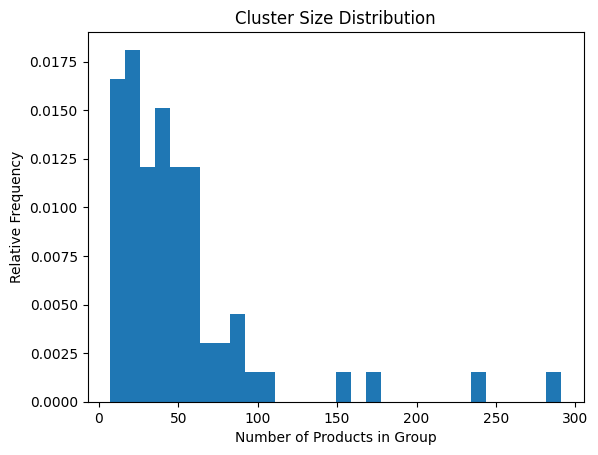

In [20]:
plt.hist(num_items, bins = 30, density = True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [21]:
products_df['label'] = labels # add a new column label where each row gets assigned a cluster number
products_df['label'].value_counts()[:5] # counts the number of products in each cluster and sort in descending order

label
44    291
8     241
0     170
4     149
23    104
Name: count, dtype: int64

In [27]:
cluster_stats[44]

{'size': 291,
 'terms': ['lp pressing', 'vinyl', 'pressing', 'vinyl lp', 'lp'],
 'sample_products': ['In Through the out Door on its release in the summer of 1979 in through the out door topped the us and uk album charts and has since been certified sixtimes platinum sadly it would be the last album that led zeppelin recorded prior to drummer john bonhams passing the following year among the seven album tracks are fool in the rain and all my love two songs that remain rock radio staples to this day the albums companion audio disc features an unreleased rough mix of every track from the original album super deluxe edition box set includes\xa0 cd1 japanese replica of the original album newly remastered in vinyl replica single wallet replica mini brown bag paintable mini insert\xa0 cd2 companion audio in a new single wallet sleeve featuring previously unreleased rough mixes of all the tracks\xa0 vinyl 1 original album newly remastered on 180 gram vinyl in a single sleeve replicating the o

In [26]:
products_df.to_csv("labeled_cds_vinyl_products.csv", index = False)